In [71]:
# Importing the modules and installing data
from pathlib import Path

module_path = Path('./modules/')

if not module_path.is_dir():
    !git clone https://github.com/abhayrokkam/learning-pytorch
    !mv learning-pytorch/06-GoingModular ./modules
    !rm -rf learning-pytorch

In [72]:
import os

import torch
import torchvision

import torchmetrics

from torchinfo import summary

from modules import data_setup, engine, utils

# Data

In [73]:
# Downloading the data
data_setup.download_data()

data_path = Path('./data/')

train_dir = data_path / 'train'
test_dir = data_path / 'test'

Important information before moving the data to dataloaders

- It is important to know the transforms that the pretrained model used for the best results.

- If the model is trained on specific type of data and we are feeding it data in a different format, the model is likely to throw errors or underperform.

- `torchvision` gives you a functionality to automatically import these transformations using the weights of the pretrained model.

In [74]:
# Initializing the weights and extracting the required transforms
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

transforms = weights.transforms()

In [75]:
# Getting the dataloaders
batch_size = 32
num_workers = int(os.cpu_count() / 2)

train_dataloader, test_dataloader, class_names = data_setup.get_dataloaders(train_dir=train_dir,
                                                                            test_dir=test_dir,
                                                                            train_transforms=transforms,
                                                                            test_transforms=transforms,
                                                                            batch_size=batch_size,
                                                                            num_workers=num_workers)

Three things to consider while choosing a pretrained model for transfer learning:
- Speed (computation units)
- Size (storage within computation device)
- Performance (customer satisfaction)

It takes a lot of experimentation to find the best model.

# Model

In [76]:
# Importing the model and the pre-trained weights
model = torchvision.models.efficientnet_b0(weights=weights)

summary(model,
        input_size=(1, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

In [77]:
# The three layers of the model
model.features
model.avgpool
print(model.classifier)

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)


Different types of transfer learning

- Feature Extraction: This is where the feature extracting layers of the model are frozen and the weights and biases only change where necessary. For a classification problem, this is the `classifier` where we will retrain the weights.

- Fine-Tuning: This is where some or all layers are updated to new weights. Usual practice is to start with a layer and continue to more layers. Fine-tuning usually required a lot of data for the model to learn the patterns efficiently.

In [78]:
# Freezing the feature extracting layers of the model
for param in model.features.parameters():
    param.requires_grad = False

In [79]:
# Updating the classifer head for our classes
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=len(class_names))
)

In [80]:
# Looking at the update
summary(model,
        input_size=(1, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

# Train

In [81]:
# Loss funciton, optimizer, accuracy
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(),
                             lr = 0.0001)

accuracy_function = torchmetrics.Accuracy(task='multiclass', num_classes=len(class_names))

In [82]:
# Device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [83]:
# Training the model
results = engine.train(epochs=25,
                       model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       loss_function=loss_function,
                       optimizer=optimizer,
                       accuracy_function=accuracy_function,
                       device=device)

  0%|          | 0/25 [00:00<?, ?it/s]


EPOCH: 0 ----------------------------------------------- 



  4%|▍         | 1/25 [00:01<00:46,  1.95s/it]

Epoch: 0  |  Loss: 1.10  |  Test Loss: 1.10  |  Test Accuracy: 0.36

EPOCH: 1 ----------------------------------------------- 

Epoch: 1  |  Loss: 1.05  |  Test Loss: 1.03  |  Test Accuracy: 0.51

EPOCH: 2 ----------------------------------------------- 



 12%|█▏        | 3/25 [00:03<00:23,  1.08s/it]

Epoch: 2  |  Loss: 1.01  |  Test Loss: 0.99  |  Test Accuracy: 0.59

EPOCH: 3 ----------------------------------------------- 



 16%|█▌        | 4/25 [00:05<00:26,  1.24s/it]

Epoch: 3  |  Loss: 0.97  |  Test Loss: 0.96  |  Test Accuracy: 0.65

EPOCH: 4 ----------------------------------------------- 



 20%|██        | 5/25 [00:06<00:28,  1.41s/it]

Epoch: 4  |  Loss: 0.94  |  Test Loss: 0.92  |  Test Accuracy: 0.69

EPOCH: 5 ----------------------------------------------- 



 24%|██▍       | 6/25 [00:08<00:27,  1.47s/it]

Epoch: 5  |  Loss: 0.93  |  Test Loss: 0.90  |  Test Accuracy: 0.71

EPOCH: 6 ----------------------------------------------- 



 28%|██▊       | 7/25 [00:09<00:27,  1.50s/it]

Epoch: 6  |  Loss: 0.90  |  Test Loss: 0.86  |  Test Accuracy: 0.76

EPOCH: 7 ----------------------------------------------- 



 32%|███▏      | 8/25 [00:11<00:25,  1.51s/it]

Epoch: 7  |  Loss: 0.87  |  Test Loss: 0.84  |  Test Accuracy: 0.79

EPOCH: 8 ----------------------------------------------- 



 36%|███▌      | 9/25 [00:13<00:24,  1.54s/it]

Epoch: 8  |  Loss: 0.85  |  Test Loss: 0.82  |  Test Accuracy: 0.76

EPOCH: 9 ----------------------------------------------- 



 40%|████      | 10/25 [00:14<00:23,  1.56s/it]

Epoch: 9  |  Loss: 0.82  |  Test Loss: 0.81  |  Test Accuracy: 0.81

EPOCH: 10 ----------------------------------------------- 



 44%|████▍     | 11/25 [00:16<00:22,  1.62s/it]

Epoch: 10  |  Loss: 0.79  |  Test Loss: 0.78  |  Test Accuracy: 0.83

EPOCH: 11 ----------------------------------------------- 



 48%|████▊     | 12/25 [00:18<00:21,  1.62s/it]

Epoch: 11  |  Loss: 0.80  |  Test Loss: 0.76  |  Test Accuracy: 0.83

EPOCH: 12 ----------------------------------------------- 



 52%|█████▏    | 13/25 [00:19<00:19,  1.62s/it]

Epoch: 12  |  Loss: 0.78  |  Test Loss: 0.73  |  Test Accuracy: 0.83

EPOCH: 13 ----------------------------------------------- 



 56%|█████▌    | 14/25 [00:21<00:17,  1.60s/it]

Epoch: 13  |  Loss: 0.75  |  Test Loss: 0.72  |  Test Accuracy: 0.84

EPOCH: 14 ----------------------------------------------- 



 60%|██████    | 15/25 [00:22<00:15,  1.59s/it]

Epoch: 14  |  Loss: 0.73  |  Test Loss: 0.71  |  Test Accuracy: 0.87

EPOCH: 15 ----------------------------------------------- 



 64%|██████▍   | 16/25 [00:24<00:14,  1.57s/it]

Epoch: 15  |  Loss: 0.71  |  Test Loss: 0.68  |  Test Accuracy: 0.82

EPOCH: 16 ----------------------------------------------- 



 68%|██████▊   | 17/25 [00:25<00:12,  1.57s/it]

Epoch: 16  |  Loss: 0.69  |  Test Loss: 0.67  |  Test Accuracy: 0.82

EPOCH: 17 ----------------------------------------------- 



 72%|███████▏  | 18/25 [00:27<00:11,  1.58s/it]

Epoch: 17  |  Loss: 0.69  |  Test Loss: 0.66  |  Test Accuracy: 0.85

EPOCH: 18 ----------------------------------------------- 



 76%|███████▌  | 19/25 [00:29<00:09,  1.57s/it]

Epoch: 18  |  Loss: 0.68  |  Test Loss: 0.65  |  Test Accuracy: 0.86

EPOCH: 19 ----------------------------------------------- 



 80%|████████  | 20/25 [00:30<00:07,  1.56s/it]

Epoch: 19  |  Loss: 0.66  |  Test Loss: 0.65  |  Test Accuracy: 0.85

EPOCH: 20 ----------------------------------------------- 



 84%|████████▍ | 21/25 [00:32<00:06,  1.54s/it]

Epoch: 20  |  Loss: 0.64  |  Test Loss: 0.64  |  Test Accuracy: 0.87

EPOCH: 21 ----------------------------------------------- 

Epoch: 21  |  Loss: 0.61  |  Test Loss: 0.62  |  Test Accuracy: 0.85

EPOCH: 22 ----------------------------------------------- 



 92%|█████████▏| 23/25 [00:33<00:02,  1.16s/it]

Epoch: 22  |  Loss: 0.62  |  Test Loss: 0.59  |  Test Accuracy: 0.87

EPOCH: 23 ----------------------------------------------- 



 96%|█████████▌| 24/25 [00:35<00:01,  1.24s/it]

Epoch: 23  |  Loss: 0.63  |  Test Loss: 0.59  |  Test Accuracy: 0.87

EPOCH: 24 ----------------------------------------------- 



100%|██████████| 25/25 [00:36<00:00,  1.47s/it]

Epoch: 24  |  Loss: 0.59  |  Test Loss: 0.59  |  Test Accuracy: 0.86


In [84]:
# Saving the model
utils.save_model(model=model,
                 target_dir='./models/',
                 model_name='25E_1e-4LR_FoodVisionMini.pth')

[INFO] Saving model to: models/25E_1e-4LR_FoodVisionMini.pth


# Loss Curves

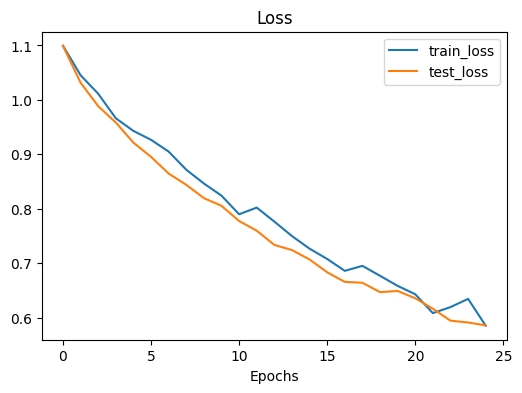

In [85]:
utils.plot_loss_curves(results)